<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/eco/ToDrive_Albedo_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter

In [4]:
# Authenticate and initialize Earth Engine
cloud_project = 'midyear-forest-427007-s7'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
  "PortArea": ee.Geometry.Point([120.967866, 14.58841]).buffer(25000),
  "ScienceGarden": ee.Geometry.Point([121.044282, 14.645072]).buffer(25000),
  "SangleyPoint": ee.Geometry.Point([120.906838, 14.494953]).buffer(25000),
  "PuertoPrinsesa": ee.Geometry.Point([118.758613, 9.740134]).buffer(25000),
  "SanJose": ee.Geometry.Point([121.04788, 12.359602]).buffer(25000),
}

start_date = "2014-01-01"
end_date   = "2024-01-01"

In [5]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract daily Albedo time series from HLS (HLSL30 for Landsat, HLSS30 for Sentinel).
    Applies interpolation and saves to CSV.
    """

    print(f"Processing Albedo for {station_name}...")

    # Landsat (HLSL30)
    hlsl = ee.ImageCollection("NASA/HLS/HLSL30/v002") \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    def landsat_albedo(img):
        date = img.date().format("YYYY-MM-dd")
        blue = img.select("B2")
        red = img.select("B4")
        nir = img.select("B5")
        swir1 = img.select("B6")
        swir2 = img.select("B7")

        albedo = (
            blue.multiply(0.356)
            .add(red.multiply(0.130))
            .add(nir.multiply(0.373))
            .add(swir1.multiply(0.085))
            .add(swir2.multiply(0.072))
            .subtract(0.0018)
        ).divide(1.016).rename("Albedo")

        return ee.Feature(
            None,
            {
                "date": date,
                "Albedo": albedo.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=geometry,
                    bestEffort=True,
                    maxPixels=1e9,
                ).get("Albedo"),
            },
        )

    hlsl_features = hlsl.map(landsat_albedo)

    # Sentinel (HLSS30)
    hlss = ee.ImageCollection("NASA/HLS/HLSS30/v002") \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    def sentinel_albedo(img):
        date = img.date().format("YYYY-MM-dd")
        blue = img.select("B2")
        red = img.select("B4")
        nir = img.select("B8")
        swir1 = img.select("B11")
        swir2 = img.select("B12")

        albedo = (
            blue.multiply(0.356)
            .add(red.multiply(0.130))
            .add(nir.multiply(0.373))
            .add(swir1.multiply(0.085))
            .add(swir2.multiply(0.072))
            .subtract(0.0018)
        ).rename("Albedo")

        return ee.Feature(
            None,
            {
                "date": date,
                "Albedo": albedo.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=geometry,
                    bestEffort=True,
                    maxPixels=1e9,
                ).get("Albedo"),
            },
        )

    hlss_features = hlss.map(sentinel_albedo)

    # Merge Landsat + Sentinel results
    features = hlsl_features.merge(hlss_features)

    # Convert to pandas
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No data for {station_name}")
        return None

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Keep original values
    df = df.rename(columns={"Albedo": "Albedo_original"})

    # Reindex to daily frequency
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    df = df.set_index("date").reindex(full_range)
    df.index.name = "date"
    df = df.reset_index()

    # Interpolation
    df["Albedo_linear"] = df["Albedo_original"].interpolate(method="linear", limit_direction="both")
    df["Albedo_spline"] = df["Albedo_original"].interpolate(method="spline", order=2, limit_direction="both")

    # Metadata
    df["station"] = station_name

    # Save
    filename = f"{station_name}_Albedo.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {df.shape[0]} rows")

    return df

In [6]:
all_dfs = {}
for station, geom in stations.items():
     all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing Albedo for PortArea...
Saved PortArea_Albedo.csv with 3653 rows
Processing Albedo for ScienceGarden...
Saved ScienceGarden_Albedo.csv with 3653 rows
Processing Albedo for SangleyPoint...
Saved SangleyPoint_Albedo.csv with 3653 rows
Processing Albedo for PuertoPrinsesa...
Saved PuertoPrinsesa_Albedo.csv with 3653 rows
Processing Albedo for SanJose...
Saved SanJose_Albedo.csv with 3653 rows


In [7]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for PortArea:


,date,Albedo_original,Albedo_linear,Albedo_spline,station
0,2014-01-01,NaN,0.607668,0.234370,PortArea
1,2014-01-02,NaN,0.607668,0.234337,PortArea
2,2014-01-03,NaN,0.607668,0.234304,PortArea
3,2014-01-04,NaN,0.607668,0.234271,PortArea
4,2014-01-05,NaN,0.607668,0.234238,PortArea


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing existing CSV files and copying to Google Drive...
CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/PortArea_Albedo.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/PortArea_Albedo_plot.png


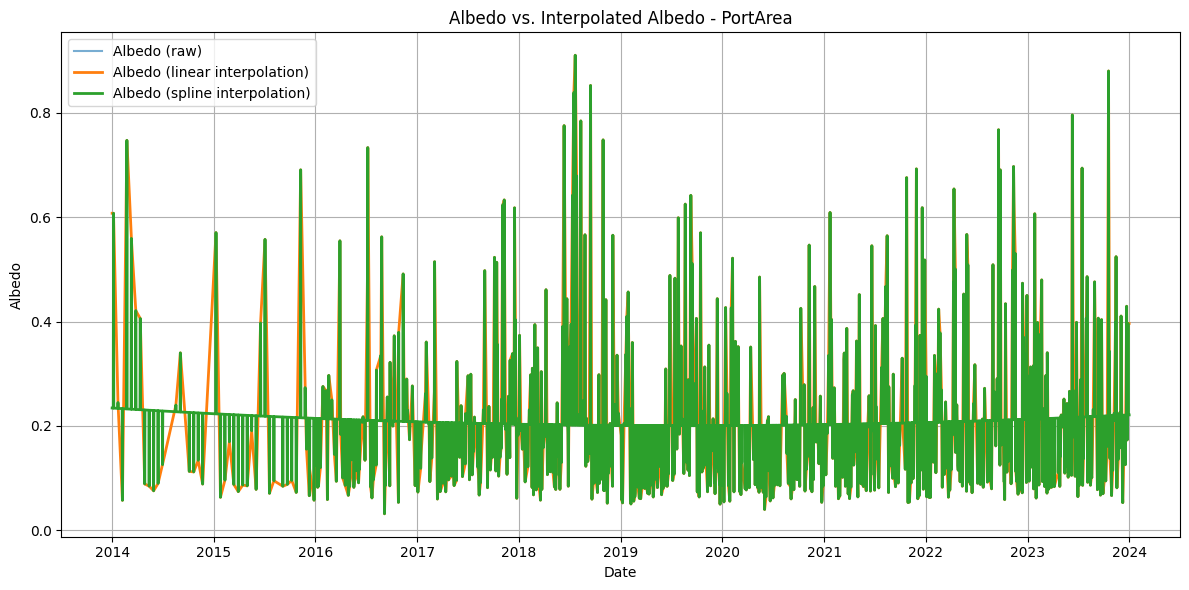

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/ScienceGarden_Albedo.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/ScienceGarden_Albedo_plot.png


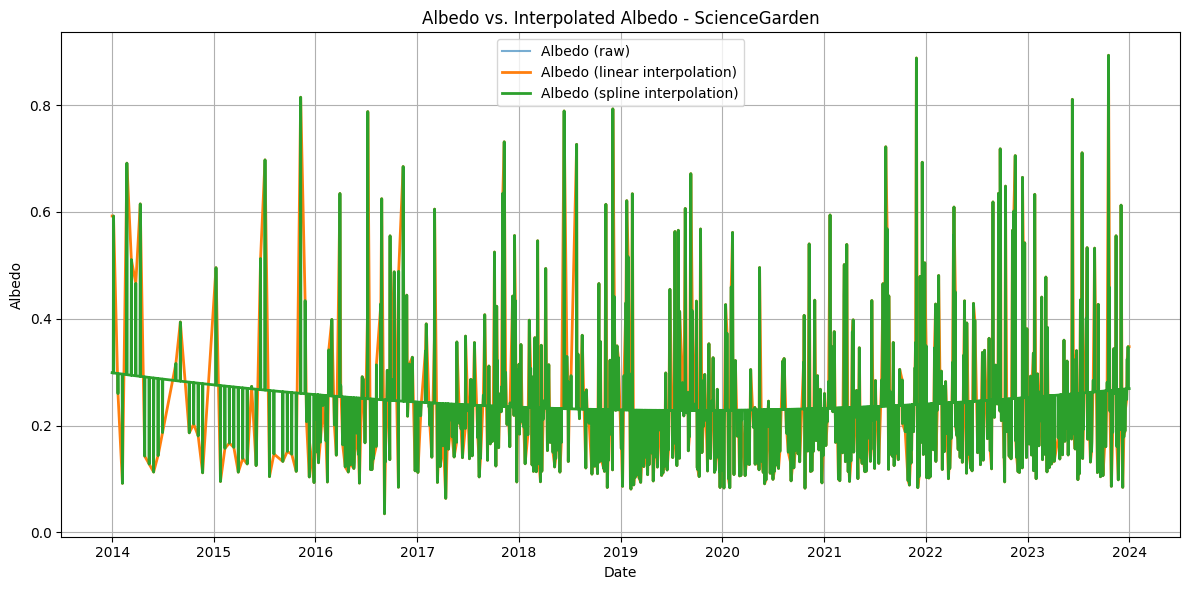

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/SangleyPoint_Albedo.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/SangleyPoint_Albedo_plot.png


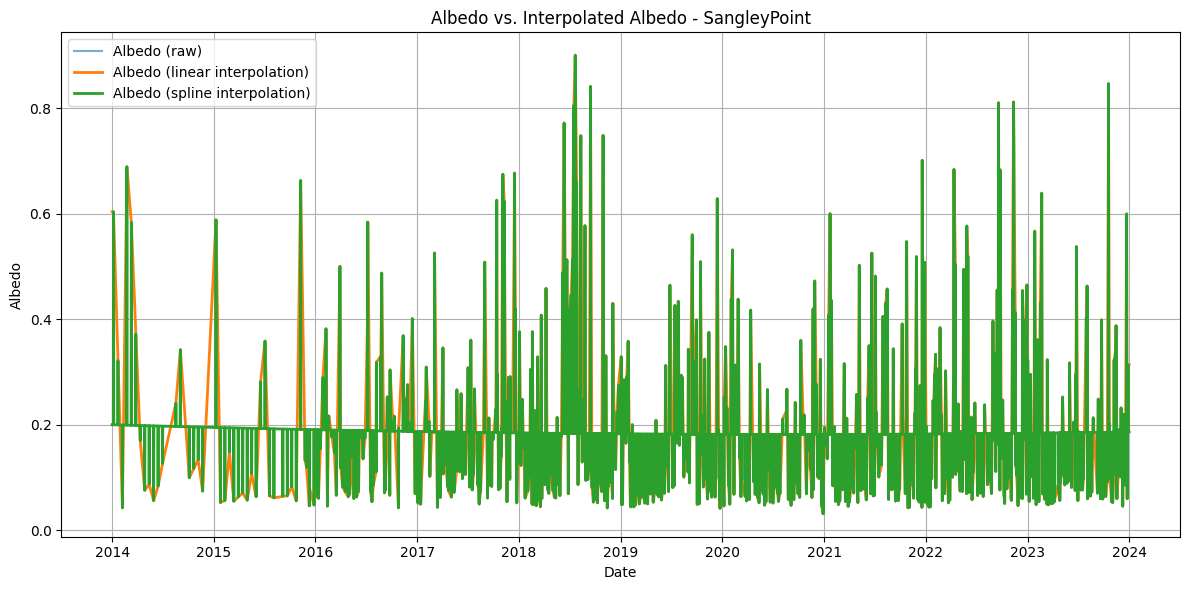

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/PuertoPrinsesa_Albedo.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/PuertoPrinsesa_Albedo_plot.png


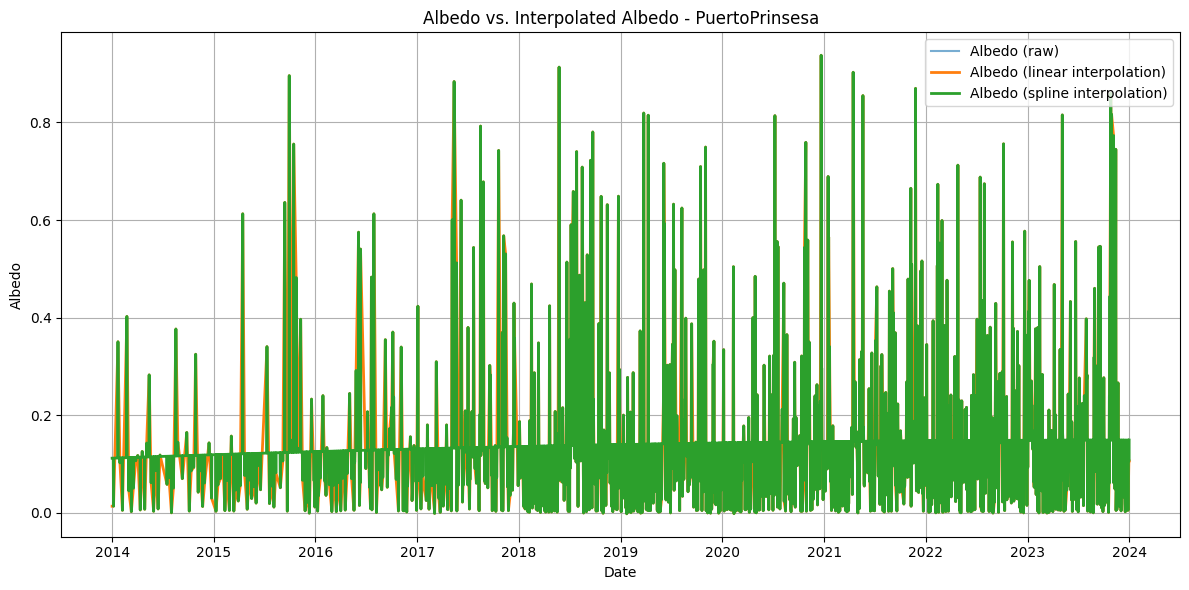

CSV saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/SanJose_Albedo.csv
Plot saved to Google Drive: /content/drive/MyDrive/Jerico_Datasets/ALBEDO/SanJose_Albedo_plot.png


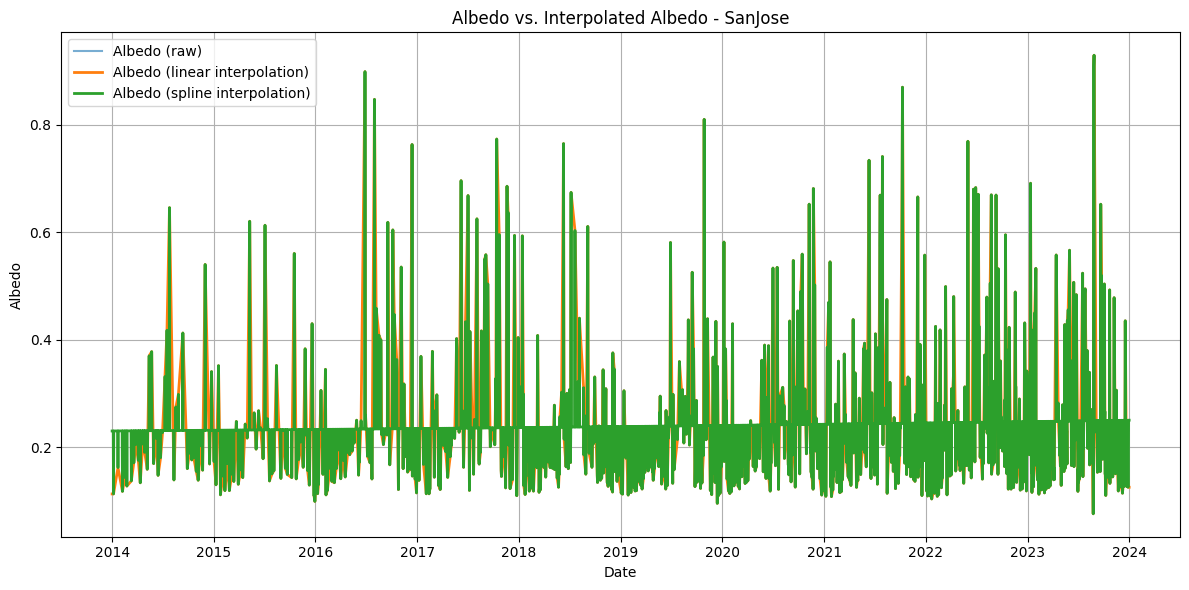


Google Drive folder created at: /content/drive/MyDrive/Jerico_Datasets/ALBEDO
You can now access your CSV files from Google Drive even after the Colab session ends!

Files in Google Drive folder:
  - PortArea_Albedo.csv
  - PortArea_Albedo_plot.png
  - ScienceGarden_Albedo.csv
  - ScienceGarden_Albedo_plot.png
  - SangleyPoint_Albedo.csv
  - SangleyPoint_Albedo_plot.png
  - PuertoPrinsesa_Albedo.csv
  - PuertoPrinsesa_Albedo_plot.png
  - SanJose_Albedo.csv
  - SanJose_Albedo_plot.png


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the Google Drive folder path where you want to save CSV files
# Modify this path to match your desired folder structure
gdrive_folder = '/content/drive/MyDrive/Jerico_Datasets/ALBEDO'  # Change this path as needed

# Create the folder if it doesn't exist
os.makedirs(gdrive_folder, exist_ok=True)

def plot_values(csv_file, station_name, save_to_gdrive=True):
    """
    Plot values and optionally save/copy CSV to Google Drive

    Args:
        csv_file: Path to the CSV file in Colab
        station_name: Name of the station
        save_to_gdrive: Whether to copy the CSV to Google Drive
    """
    # Load CSV (expects columns: date, Albedo_original, Albedo_linear, Albedo_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Copy CSV to Google Drive if requested
    if save_to_gdrive:
        gdrive_csv_path = os.path.join(gdrive_folder, csv_file)
        df.to_csv(gdrive_csv_path, index=False)
        print(f"CSV saved to Google Drive: {gdrive_csv_path}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["Albedo_original"], label="Albedo (raw)", alpha=0.6)
    plt.plot(df["date"], df["Albedo_linear"], label="Albedo (linear interpolation)", linewidth=2)
    plt.plot(df["date"], df["Albedo_spline"], label="Albedo (spline interpolation)", linewidth=2)

    plt.xlabel("Date")
    plt.ylabel("Albedo")
    plt.title(f"Albedo vs. Interpolated Albedo - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Optionally save the plot to Google Drive as well
    if save_to_gdrive:
        plot_filename = f"{station_name}_Albedo_plot.png"
        plot_path = os.path.join(gdrive_folder, plot_filename)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to Google Drive: {plot_path}")

    plt.show()

# Alternative function to work directly with Google Drive paths
def create_and_save_csv_to_gdrive(data, filename, station_name):
    """
    Create a CSV from data and save directly to Google Drive

    Args:
        data: DataFrame or data to save
        filename: Name of the CSV file
        station_name: Station name for the plot
    """
    # Save directly to Google Drive
    gdrive_csv_path = os.path.join(gdrive_folder, filename)

    if isinstance(data, pd.DataFrame):
        data.to_csv(gdrive_csv_path, index=False)
    else:
        # If data is not a DataFrame, convert it
        df = pd.DataFrame(data)
        df.to_csv(gdrive_csv_path, index=False)

    print(f"CSV created and saved to Google Drive: {gdrive_csv_path}")
    return gdrive_csv_path

# Method 1: Process existing CSV files and copy them to Google Drive
station_names = ["PortArea", "ScienceGarden", "SangleyPoint", "PuertoPrinsesa", "SanJose"]

print("Processing existing CSV files and copying to Google Drive...")
for station in station_names:
    csv_file = f"{station}_Albedo.csv"
    if os.path.exists(csv_file):  # Check if file exists in Colab
        plot_values(csv_file, station, save_to_gdrive=True)
    else:
        print(f"Warning: {csv_file} not found in Colab directory")

# Method 2: If you're generating CSV files from data, save directly to Google Drive
def process_and_save_station_data(station_data, station_name):
    """
    Example function showing how to process data and save directly to Google Drive

    Args:
        station_data: Your processed data (DataFrame)
        station_name: Name of the station
    """
    # Process your data here (interpolation, etc.)
    # This is just an example - replace with your actual data processing

    # Save directly to Google Drive
    csv_filename = f"{station_name}_Albedo.csv"
    gdrive_csv_path = os.path.join(gdrive_folder, csv_filename)

    station_data.to_csv(gdrive_csv_path, index=False)
    print(f"Processed data saved to Google Drive: {gdrive_csv_path}")

    # Plot using the Google Drive file
    plot_values_from_gdrive(gdrive_csv_path, station_name)

def plot_values_from_gdrive(gdrive_csv_path, station_name):
    """
    Plot values directly from Google Drive CSV file
    """
    df = pd.read_csv(gdrive_csv_path, parse_dates=["date"])

    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["Albedo_original"], label="Albedo (raw)", alpha=0.6)
    plt.plot(df["date"], df["Albedo_linear"], label="Albedo (linear interpolation)", linewidth=2)
    plt.plot(df["date"], df["Albedo_spline"], label="Albedo (spline interpolation)", linewidth=2)

    plt.xlabel("Date")
    plt.ylabel("Albedo")
    plt.title(f"Albedo vs. Interpolated Albedo - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print(f"\nGoogle Drive folder created at: {gdrive_folder}")
print("You can now access your CSV files from Google Drive even after the Colab session ends!")

# Optional: List files in Google Drive folder
print(f"\nFiles in Google Drive folder:")
if os.path.exists(gdrive_folder):
    for file in os.listdir(gdrive_folder):
        print(f"  - {file}")
else:
    print("  No files yet - run the processing functions above")